## Machine Learning-Based H1N1 and Seasonal Flu Prediction: An extensive data-driven examination of the correlation between predictive models and pupils’ background.

### Objective

The primary objective of this project is to develop and implement a multilabel classification model that predicts whether individuals will receive the H1N1 vaccine, the seasonal flu vaccine, or both. This model will utilize a variety of demographic, behavioral, and opinion-based features to accurately classify vaccination intentions. The end goal is to identify key factors that influence an individual's decision to get vaccinated, which can then be used to design targeted public health interventions. This project will also conduct a detailed analysis of the interrelationships between different features to uncover significant patterns and insights that deepen our understanding of vaccination behaviors.

The main source of data is provided courtesy of the United States National Center for Health Statistics. U.S. Department of Health and Human Services (DHHS). National Center for Health Statistics. The National 2009 H1N1 Flu Survey. Hyattsville, MD: Centers for Disease Control and Prevention, 2012: https://www.cdc.gov/nchs/nis/data_files_h1n1.htm 

The research question has been clearly outlined in 'Research Questions'.

### Research Questions

- __(1)__ How do demographic factors (age, education, income) influence perceptions of H1N1 and seasonal flu vaccine effectiveness and risks? - This comparative question investigates how background factors affect beliefs about vaccine safety and efficacy, potentially impacting vaccination rates.

- __(2)__ Is there a correlation between engaging in preventative health behaviors (handwashing, face masks) and the likelihood of getting vaccinated? - This associative question explores whether individuals practicing preventative measures are more likely to get vaccinated, indicating a broader health-conscious attitude.

First, it is essential we import the necessary libraries. Importing libraries provides essential tools and functions, preventing the need to "reinvent the wheel". Importing in one block improves code organisation and ensures all dependencies are ready. Moreover, importing only necessary libraries to optimise memory usage and avoiding potential conflicts.

In [1]:
### importing libraries

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import sklearn as sk
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import calibration_curve
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import svm, model_selection, tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import xgboost as xgb
import os

# enabling HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

Let us read the data files. The training set features and training set labels have a data set each, so we will import them using x and y. x will represent the features, and y will represent the labels:

In [2]:
# loading csv files into dataframes with lowercase variable names for x and y
file_path_features = './training_set_features.csv'
file_path_labels = './training_set_labels.csv'

x = pd.read_csv(file_path_features)
y = pd.read_csv(file_path_labels)

#### Combining training values and training labels into one dataframe

In [3]:
print(f"The shape of x is: ", x.shape)
print(f"The shape of y is: ", y.shape)

The shape of x is:  (26707, 36)
The shape of y is:  (26707, 3)


We can observe there are 36 features in the training set, and 3 labels in the label set. The label is seen as 'ground truth'. The 3 labels are: `h1n1_vaccine`, `seasonal_vaccine`, and `respondent_id`

Kindly note that 'ground truth' is referring to the actual, real-world values or labels that are used as a reference to train and evaluate models. These are the accurate and verified data points against which predictions made by the model are compared to assess its performance.

Before we do any kind of data pre-processing/wrangling we need to concatenate the 2 datasets into one:

In [4]:
z = y.copy() 
z.drop('respondent_id', axis=1, inplace=True)
frames = [x, z] # joining the x & y into a single dataframe
data = pd.concat(frames, axis=1)

Let us have a look at the head of the data:

In [5]:
data.insert(0, 'id', range(1, 1 + len(data)))
data

,id,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,2,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,3,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,4,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,5,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26703,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26704,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26705,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26706,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


### Data Pre-processing / Wrangling

Here are the pre-processing tasks we'll perform:

1. Remove duplicated entries
2. Handle missing data
3. Address outliers and bad data

#### Copying training data file

Next step is to create two separate files - 'data_m1' and 'data_m2'. These files will go through the same pre-processing steps, but with some differences in the way they are processed. By doing so we can observe and compare the effects that different pre-processing and data wrangling methods will have on the final classification models.

In [6]:
data_m1 = data.copy()
data_m2 = data.copy()

#### Identifying and dealing with duplicates

As for duplicates, there aren't multiple methods of identifying, pandas provides a simple effective function to do so:

##### Method A - First approach is to simply remove the entries in the dataset that have missing values

In [7]:
duplicates_data_m1 = data_m1[data_m1.duplicated(keep=False)]
print(duplicates_data_m1)

Empty DataFrame
Columns: [id, respondent_id, h1n1_concern, h1n1_knowledge, behavioral_antiviral_meds, behavioral_avoidance, behavioral_face_mask, behavioral_wash_hands, behavioral_large_gatherings, behavioral_outside_home, behavioral_touch_face, doctor_recc_h1n1, doctor_recc_seasonal, chronic_med_condition, child_under_6_months, health_worker, health_insurance, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, opinion_seas_sick_from_vacc, age_group, education, race, sex, income_poverty, marital_status, rent_or_own, employment_status, hhs_geo_region, census_msa, household_adults, household_children, employment_industry, employment_occupation, h1n1_vaccine, seasonal_vaccine]
Index: []

[0 rows x 39 columns]


#### Identifying and dealing with missing values in the dataset

##### Method A: Check for NaNs and Special Characters

This code will systematically check for and count NaN values, question marks, and exclamation marks in the data set, then print their counts and positions. This helps in identifying potential data issues that need to be addressed for accurate analysis and processing:

In [8]:
# checking if there are any NaN values, question marks or exclamation marks
if data_m1.isna().any().any() or any('?' in str(val) or '!' in str(val) for val in data_m1.values.flatten()):

    # print a message indicating there are NaN values, question marks or exclamation marks
    print("There are:")

    # count the number of NaN values
    num_nan = data_m1.isna().sum().sum()
    print(f"{num_nan} NaN values")

    # count the number of question marks
    num_question_marks = sum('?' in str(val) for val in data_m1.values.flatten())
    print(f"{num_question_marks} question marks")

    # count the number of exclamation marks
    num_exclamation_marks = sum('!' in str(val) for val in data_m1.values.flatten())
    print(f"{num_exclamation_marks} exclamation marks")

    # use stack() and reset_index() to create a DataFrame of the NaN and special character positions
    nan_positions = pd.DataFrame(data_m1.isna().stack()[lambda x: x].index.tolist(), columns=['row', 'column'])
    special_positions = pd.DataFrame([(i,j) for i, row in enumerate(data_m1.values) for j, val in enumerate(row) if '?' in str(val) or '!' in str(val)], columns=['row', 'column'])
    positions = pd.concat([nan_positions, special_positions], ignore_index=True)

    # print the positions of NaN and special characters values
    print("The positions of NaN and special character values are:")
    print(positions)
else:
    print("There are no NaN values, question marks or exclamation marks in the DataFrame")


There are:
60762 NaN values
0 question marks
0 exclamation marks
The positions of NaN and special character values are:
         row                 column
0          0    employment_industry
1          0  employment_occupation
2          2       doctor_recc_h1n1
3          2   doctor_recc_seasonal
4          2       health_insurance
...      ...                    ...
60757  26704    employment_industry
60758  26704  employment_occupation
60759  26705  behavioral_touch_face
60760  26706    employment_industry
60761  26706  employment_occupation

[60762 rows x 2 columns]


We can conclude there are 60,762 NaN values in the DataFrame, indicating substantial missing data, while no question marks or exclamation marks are present. The positions of these NaN values span various columns like `employment_industry`, `employment_occupation`, and `doctor_recc_h1n1`. This necessitates handling the missing data through imputation or exclusion to maintain data integrity for accurate analysis.

Now, we want to know where exactly the missing values are:

In [9]:
data_m1.shape

(26707, 39)

The original size of the data is (26,707 entries by 36 features and 3 labels)

This code prints out the exact total number of entries in the data set and lists each feature (column) along with the count of its missing values, allowing for a closer examination of which features have missing data and how many entries are missing for each feature. This helps facilitate decisions on data cleaning and preprocessing:

In [10]:
print("All features contain a total number of 26,707 entries. The missing features are as follows: ")
for column in data_m1.columns:
    missing_count = data_m1[column].isna().sum()
    print(f"{column}: {missing_count}")

All features contain a total number of 26,707 entries. The missing features are as follows: 
id: 0
respondent_id: 0
h1n1_concern: 92
h1n1_knowledge: 116
behavioral_antiviral_meds: 71
behavioral_avoidance: 208
behavioral_face_mask: 19
behavioral_wash_hands: 42
behavioral_large_gatherings: 87
behavioral_outside_home: 82
behavioral_touch_face: 128
doctor_recc_h1n1: 2160
doctor_recc_seasonal: 2160
chronic_med_condition: 971
child_under_6_months: 820
health_worker: 804
health_insurance: 12274
opinion_h1n1_vacc_effective: 391
opinion_h1n1_risk: 388
opinion_h1n1_sick_from_vacc: 395
opinion_seas_vacc_effective: 462
opinion_seas_risk: 514
opinion_seas_sick_from_vacc: 537
age_group: 0
education: 1407
race: 0
sex: 0
income_poverty: 4423
marital_status: 1408
rent_or_own: 2042
employment_status: 1463
hhs_geo_region: 0
census_msa: 0
household_adults: 249
household_children: 249
employment_industry: 13330
employment_occupation: 13470
h1n1_vaccine: 0
seasonal_vaccine: 0


We are dropping the columns `health_insurance`, `employment_industry`, and `employment_occupation` from the data set because close to half of their values are NULL, ensuring data quality and reliability.

In [11]:
data_m1.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

Next, we are selecting columns with string (objects) data types from the data set and displaying the first few rows of these columns to examine their contents. This helps us understand the nature of categorical data in the data set and identify any potential issues or patterns that need to be addressed:

In [12]:
str_cols = data_m1.select_dtypes(include = 'object').columns
data_m1[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


We are filling all NULL values with the median for numeric columns and the mode for categorical columns to handle missing data. This approach preserves the central tendency of the data and ensures that we can use the complete data set for analysis without introducing significant bias:

First, let's analyse what type of data types are in the data so we can ensure to impute them in the KNN imputation.

In [13]:
print(data_m1.dtypes)

id                               int64
respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

label_encoders = {}
for column in data_m1.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_m1[column] = data_m1[column].astype(str)  # ensure all entries are strings
    data_m1[column] = le.fit_transform(data_m1[column])
    label_encoders[column] = le

    #iterative imputer now : 

imputer = IterativeImputer(random_state=0)
data_m1_imputed = pd.DataFrame(imputer.fit_transform(data_m1), columns=data_m1.columns)

# decoding categorical columns back to original
for column in label_encoders:
    le = label_encoders[column]
    data_m1_imputed[column] = le.inverse_transform(data_m1_imputed[column].round().astype(int))

data_m1 = data_m1_imputed

When checking for any missing data entries now, we can see there are none.

In [15]:
for column in data_m1.columns:
    missing_count = data_m1[column].isna().sum()
    print(f"{column}: {missing_count}")

id: 0
respondent_id: 0
h1n1_concern: 0
h1n1_knowledge: 0
behavioral_antiviral_meds: 0
behavioral_avoidance: 0
behavioral_face_mask: 0
behavioral_wash_hands: 0
behavioral_large_gatherings: 0
behavioral_outside_home: 0
behavioral_touch_face: 0
doctor_recc_h1n1: 0
doctor_recc_seasonal: 0
chronic_med_condition: 0
child_under_6_months: 0
health_worker: 0
opinion_h1n1_vacc_effective: 0
opinion_h1n1_risk: 0
opinion_h1n1_sick_from_vacc: 0
opinion_seas_vacc_effective: 0
opinion_seas_risk: 0
opinion_seas_sick_from_vacc: 0
age_group: 0
education: 0
race: 0
sex: 0
income_poverty: 0
marital_status: 0
rent_or_own: 0
employment_status: 0
hhs_geo_region: 0
census_msa: 0
household_adults: 0
household_children: 0
h1n1_vaccine: 0
seasonal_vaccine: 0


In [16]:
missing_values = data_m1.isnull().sum()

missing_columns = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Columns with missing values and the count of missing values in each column:")
    print(missing_columns)
else:
    print("There are no missing values in the dataset.")

There are no missing values in the dataset.


##### Method B: 

In [17]:
def fill_missing_values(column):
    if column.isnull().any():
        if column.dtype != 'object':
            return column.fillna(column.median())
        else:
            return column.fillna(column.mode()[0])
    return column

data_m2 = data_m2.apply(fill_missing_values, axis=0)

In [18]:
# subset of data testing: only 10% of the dataset
data_m2 = data_m2.sample(frac=0.1, random_state=42).reset_index(drop=True)

#### Identifying and dealing with outliers and placeholders

The original plan was to handle outliers and potential placeholders using two different methods to compare their impact on the final classification model.

First approach (method 1):

- Remove extreme outliers, such as values above the 95% quantile and below the 5% quantile.
- For all other outliers, use mean imputation where possible.


Second approach (method 2):

- Remove extreme outliers, such as values above the 95% quantile and below the 5% quantile.
- For all other outliers, use median imputation where possible.

Refer to the section below for the justification of why this plan was not implemented.

##### Method A & B - Justification of not removing outliers by discarding the extremes.


Removing extreme outliers was considered, but the model performed significantly better with the training data, achieving an average of 80%. This indicates a lack of generalisability and suggests the model is overfitting to the current data. Cross-validation scores were between 90-95% with the outliers removed, compared to 80% when they were included, further highlighting the issue. This also implies that the outliers contain crucial information.

Reason for not removing outliers:

- Avoiding Reduced Robustness: Removing outliers may lead to a model that doesn't perform well on new, unseen data, hence reducing the overall robustness.
- Preserving Strong Correlations: Outliers may represent important variations in the data that are critical for capturing underlying patterns and relationships.
- Importance of All Data Points: Every data point, including outliers, can provide valuable information. Removing them may result in a loss of significant insights.

Note that the aim is to apply the best practices consistently. We do not intentionally omit steps that others have used, as this would be a clear disadvantage.

### Feature Selection and Engineering

##### Method A - Exploratory Data Analysis

We are identifying string columns in the data set and encoding them to int64 using LabelEncoder to convert categorical data into a numerical format suitable for machine learning models:

In [19]:
str_cols = data_m1.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in str_cols:
    data_m1[col] = le.fit_transform(data_m1[col])

We will display the first few rows of the encoded string columns to verify that the encoding was performed correctly:

In [20]:
data_m1[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,3,1,3,0,2,1,0,1,8,2
1,1,0,3,1,2,1,1,0,1,0
2,0,2,3,1,0,1,0,0,9,0
3,4,0,3,0,2,1,1,1,5,1
4,2,3,3,0,0,0,0,0,9,0


We are calculating the correlation matrix of the data set and visualizing it using a heatmap. This helps in identifying relationships between features, with annotations and a color map to enhance readability:

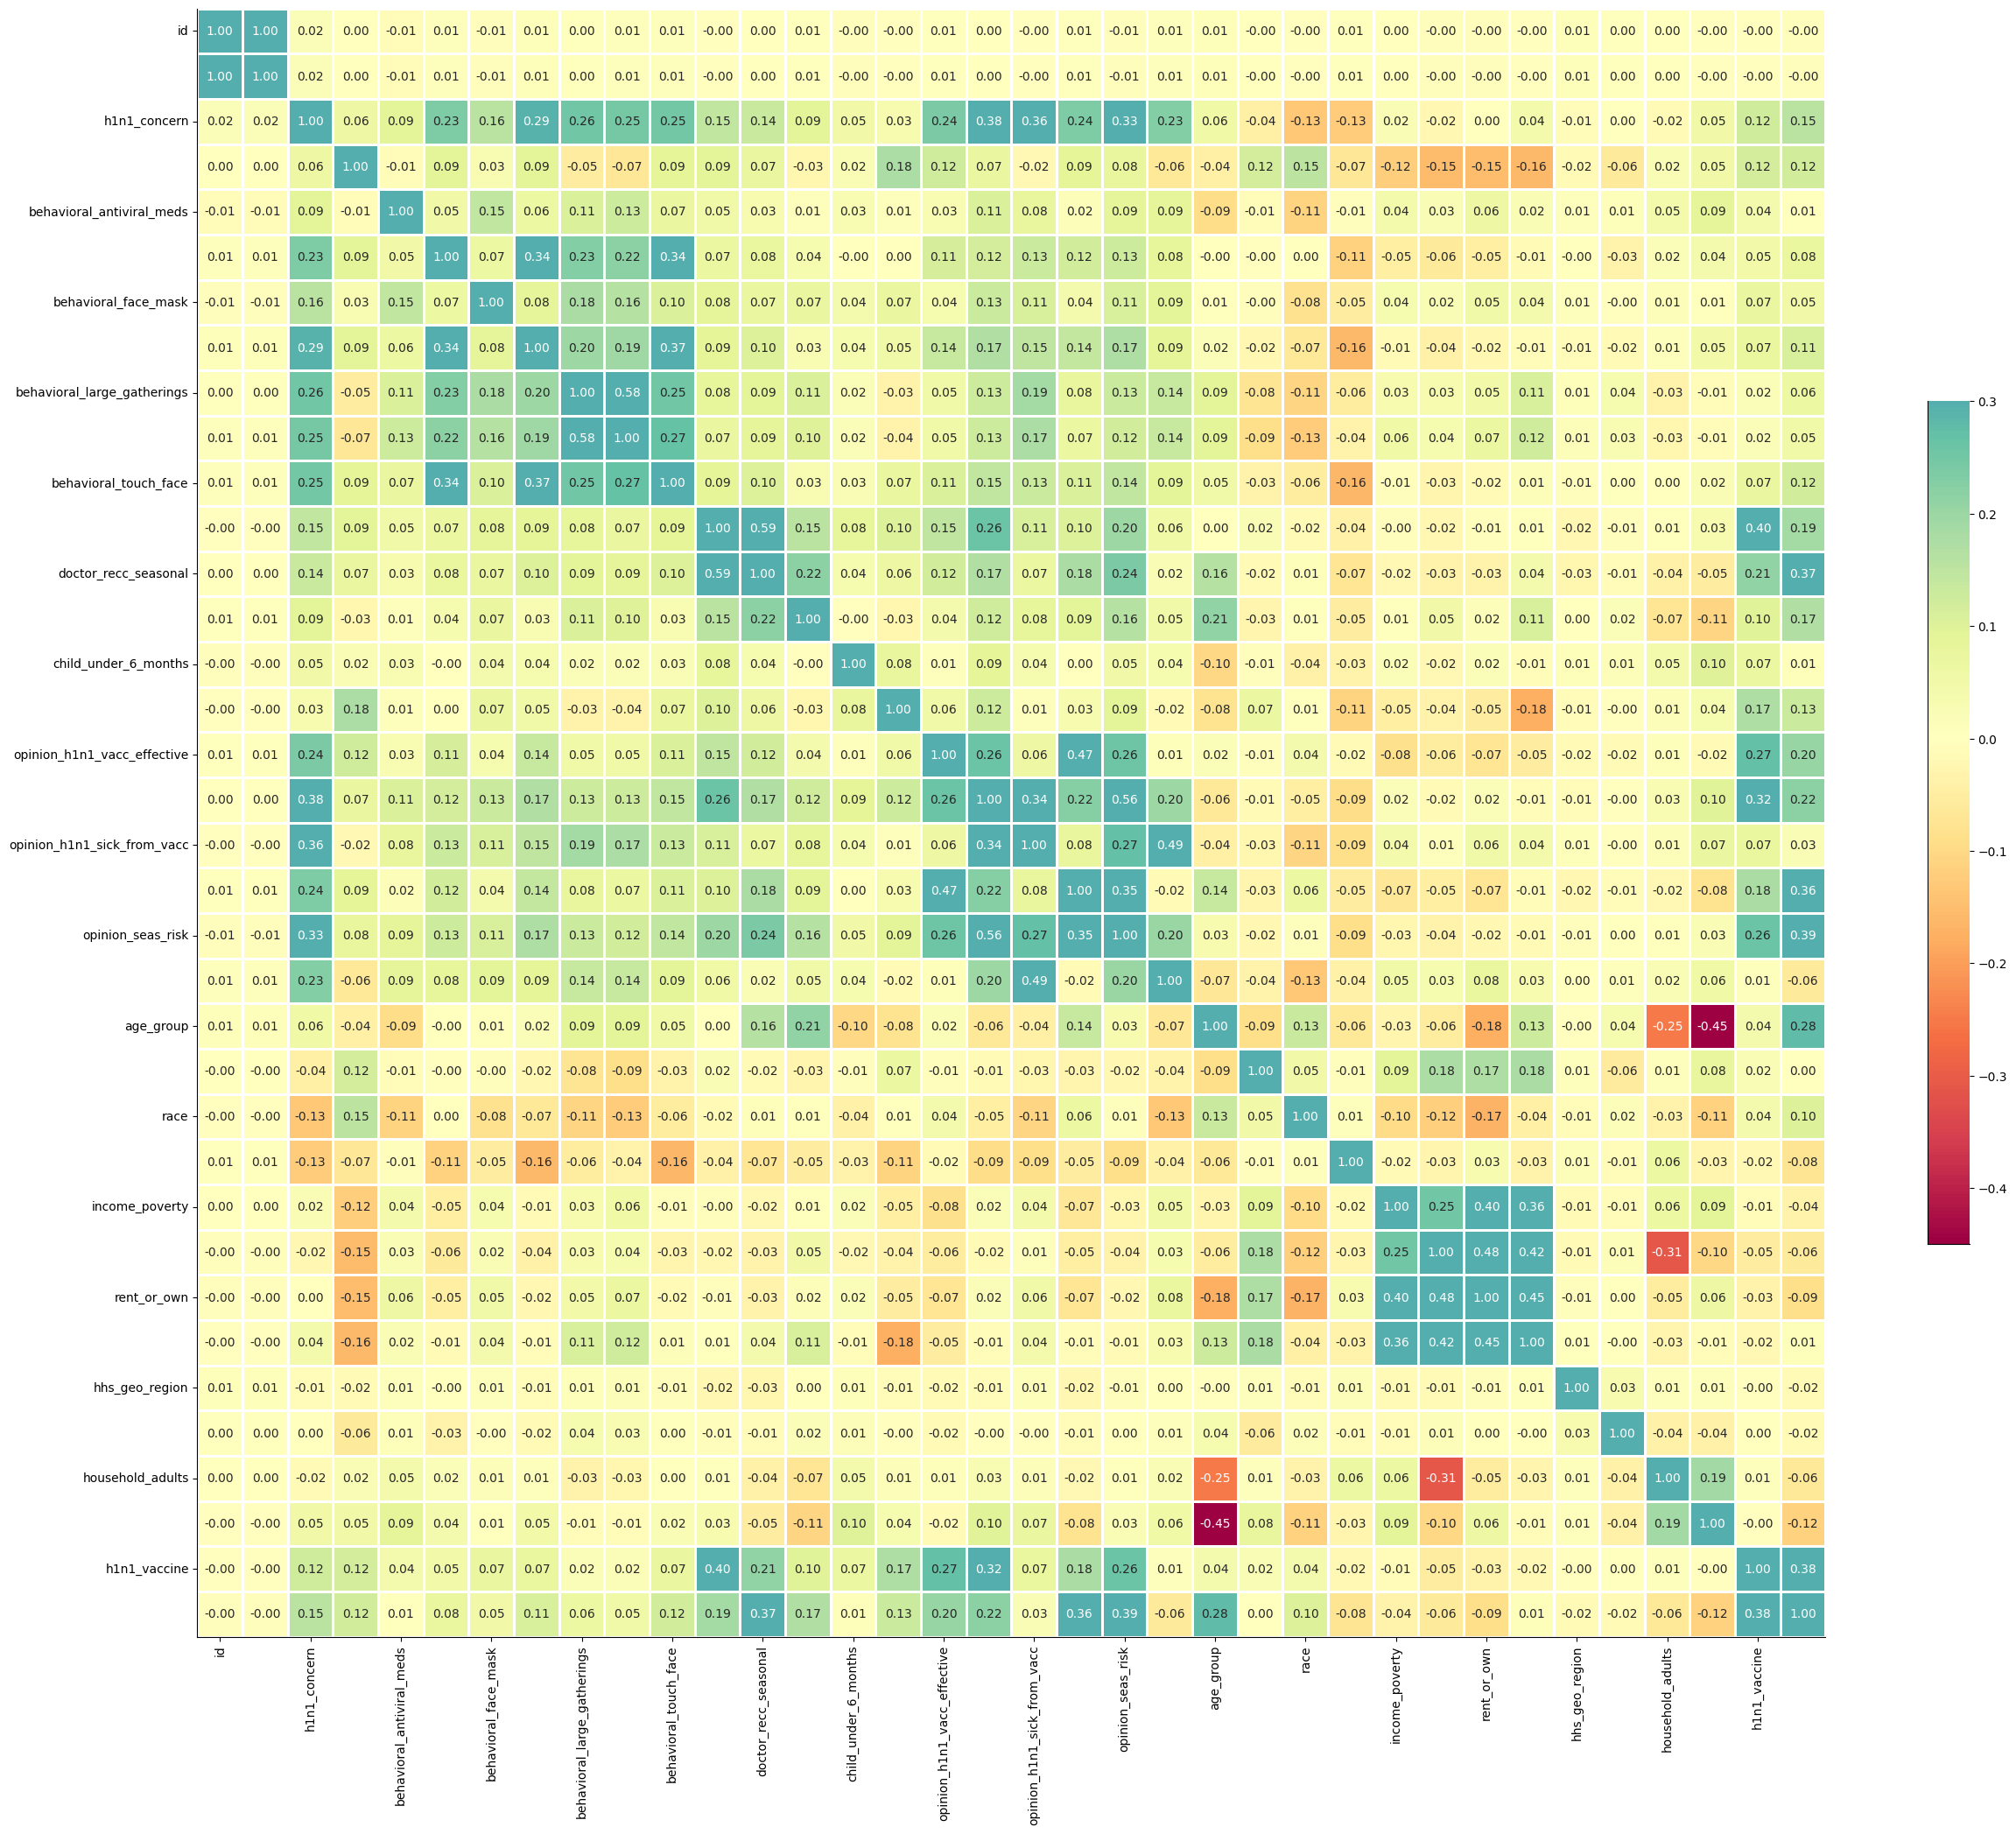

In [21]:
corr = data_m1.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# filtering the data frame to include only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# calculating the correlation matrix using only numeric columns
corr_matrix = numeric_data.corr()

# Print out all the variable names listed in the correlation matrix
variables = corr_matrix.columns.tolist()
print("Variables in the correlation matrix:")
for var in variables:
    print(var)


Variables in the correlation matrix:
id
respondent_id
h1n1_concern
h1n1_knowledge
behavioral_antiviral_meds
behavioral_avoidance
behavioral_face_mask
behavioral_wash_hands
behavioral_large_gatherings
behavioral_outside_home
behavioral_touch_face
doctor_recc_h1n1
doctor_recc_seasonal
chronic_med_condition
child_under_6_months
health_worker
health_insurance
opinion_h1n1_vacc_effective
opinion_h1n1_risk
opinion_h1n1_sick_from_vacc
opinion_seas_vacc_effective
opinion_seas_risk
opinion_seas_sick_from_vacc
household_adults
household_children
h1n1_vaccine
seasonal_vaccine


In [23]:
# variable1 = 'seasonal_vaccine'
# variable2 = 'behavioral_avoidance'

# correlation_value = corr.loc[variable1, variable2]

# print(f"Correlation between '{variable1}' and '{variable2}': {correlation_value:.2f}")


In [24]:
# import pandas as pd
# from scipy.stats import pearsonr

# df = data_m1.copy()

# variable1 = 'age_group'
# variable2 = 'opinion_seas_vacc_effective'

# if df[variable1].dtype == 'object':
#     df[variable1] = pd.to_numeric(df[variable1], errors='coerce')

# if df[variable2].dtype == 'object':
#     df[variable2] = pd.to_numeric(df[variable2], errors='coerce')

# df_clean = df.dropna(subset=[variable1, variable2])

# correlation, p_value = pearsonr(df_clean[variable1], df_clean[variable2])

# print(f'Correlation between {variable1} and {variable2}: {correlation}')
# print(f'P-value: {p_value}')


**OBSERVATIONS**:

*  There are high positive correlations between the 'behavioral_features', indicating potential redundancy among them.

*  Strong positive correlations are observed between the opinion of H1N1 risk, doctor's recommendation of vaccines, and whether the person actually took the vaccine, which is expected.

* Overall, the features tend to positively correlate with the act of taking the vaccination, with few exceptions.

* There are several redundant or weakly correlated features that should be addressed.

We are visualizing the correlation matrix of the string columns in the data set after encoding them. This helps in understanding the relationships between categorical features, identifying highly correlated features, and addressing redundancy:

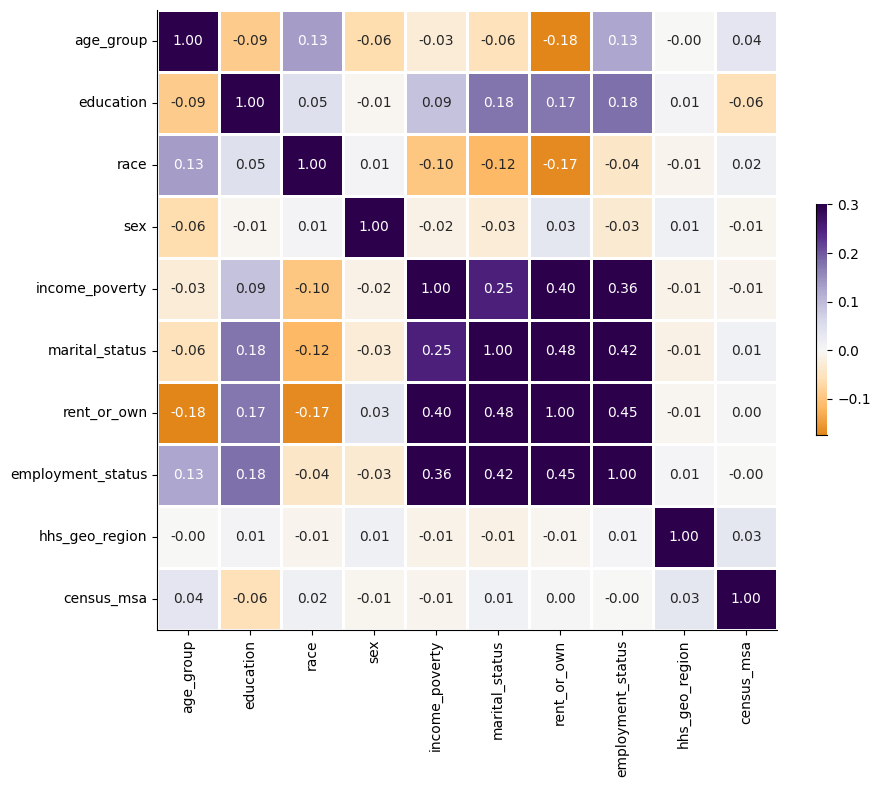

In [25]:
datum = data_m1[str_cols]
corr = datum.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .3}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
g.figure.set_size_inches(10,10)
    
plt.show()

From the correlation matrix heatmap, `rent_or_own` is moderately positively correlated with `marital_status` (0.30) and negatively correlated with `age_group` (-0.21) and `race` (-0.20). `employment_status` and `age_group` also show a moderate positive correlation (0.25). Most other features exhibit weak correlations, indicating limited linear relationships among them. However, we will use MLR to capture the complex relationships between the data.

Next, we are creating a new column 'cleanliness' by summing the relevant behavioral columns to capture the overall cleanliness behavior of individuals. This combined metric provides a comprehensive measure of hygiene practices, which can be valuable for understanding its impact on health outcomes and vaccination decisions:

In [26]:
# create a new 'cleanliness' column by summing relevant behavioral columns
data_m1['cleanliness'] = (data_m1['behavioral_antiviral_meds'] + data_m1['behavioral_avoidance'] +
                       data_m1['behavioral_face_mask'] + data_m1['behavioral_wash_hands'] +
                       data_m1['behavioral_large_gatherings'] + data_m1['behavioral_outside_home'] +
                       data_m1['behavioral_touch_face'])


We are creating a new column 'opinion' by summing the relevant opinion columns to capture the overall sentiment and perception towards vaccines. This aggregated metric helps in understanding how opinions about vaccine effectiveness, risks, and sickness from vaccines influence vaccination behaviour:

In [27]:
# also creating a new 'opinion' column by summing relevant opinion columns
data_m1['opinion'] = (data_m1['opinion_h1n1_vacc_effective'] + data_m1['opinion_h1n1_risk'] +
                   data_m1['opinion_h1n1_sick_from_vacc'] + data_m1['opinion_seas_vacc_effective'] +
                   data_m1['opinion_seas_risk'] + data_m1['opinion_seas_sick_from_vacc'])


We are creating two new columns, 'opinion_h1n1' and 'opinion_seasonal', to capture overall sentiment towards the H1N1 and seasonal vaccines by combining relevant opinion columns on effectiveness, risk, and concerns about sickness from the vaccines. This aggregation simplifies the analysis by reducing the number of features and highlights key attitudes towards each vaccine, which can significantly influence vaccination behavior. Combining these columns is justified as it provides a more comprehensive and interpretable metric for understanding the overall opinion towards each vaccine:

In [28]:
data_m1['opinion_h1n1'] = (data_m1['opinion_h1n1_vacc_effective'] + data_m1['opinion_h1n1_risk'] -
                        data_m1['opinion_h1n1_sick_from_vacc'])
data_m1['opinion_seasonal'] = (data_m1['opinion_seas_vacc_effective'] + data_m1['opinion_seas_risk'] -
                            data_m1['opinion_seas_sick_from_vacc'])

data_m1['concern>=2'] = np.where(data_m1['h1n1_concern'] >= 2, 1, 0)

data_m1['good_opinion_vacc'] = np.where(data_m1['opinion_seas_vacc_effective'] == 3, 1, 0)

data_m1['good_knowledge'] = np.where(data_m1['h1n1_knowledge'] == 2, 1, 0)


**NOTE**:

* `concern>=2`: Indicates high concern (1) if `h1n1_concern` is 2 or more, otherwise 0.

* `Good_opinion_vacc`: Indicates a very positive opinion (1) if `opinion_seas_vacc_effective` is 3, otherwise 0.

* `good_knowledge`: Indicates good knowledge (1) if `h1n1_knowledge` is 2, otherwise 0.

These transformations make it easier to interpret and analyze key thresholds in the data.

We are creating new columns using vectorized operations for efficiency:

In [29]:
data_m1['risk'] = (data_m1['opinion_h1n1_risk'] >= 4).astype(int) # new columns using vectorized operations for efficiency
data_m1['concern_knowledge'] = data_m1['h1n1_concern'] + data_m1['h1n1_knowledge']
data_m1['a^2'] = data_m1['age_group'] ** 2

**NOTE**:

* `risk`: Indicates high risk (1) if `opinion_h1n1_risk` is 4 or more, otherwise 0. This binary indicator simplifies the analysis of risk perception.

* `concern_knowledge`: Combines h1n1_concern and `h1n1_knowledge` to capture overall awareness and concern about H1N1, providing a comprehensive measure of both factors.

* `a^2`: Squares the `age_group` column to explore non-linear age effects, enabling us to capture potential quadratic relationships with other features.

In [30]:
data_m1.columns

Index(['id', 'respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk', 'concern_knowledge', 'a^2'],
  

['id', 'respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'household_adults', 'household_children', 'h1n1_vaccine', 'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge', 'a^2']


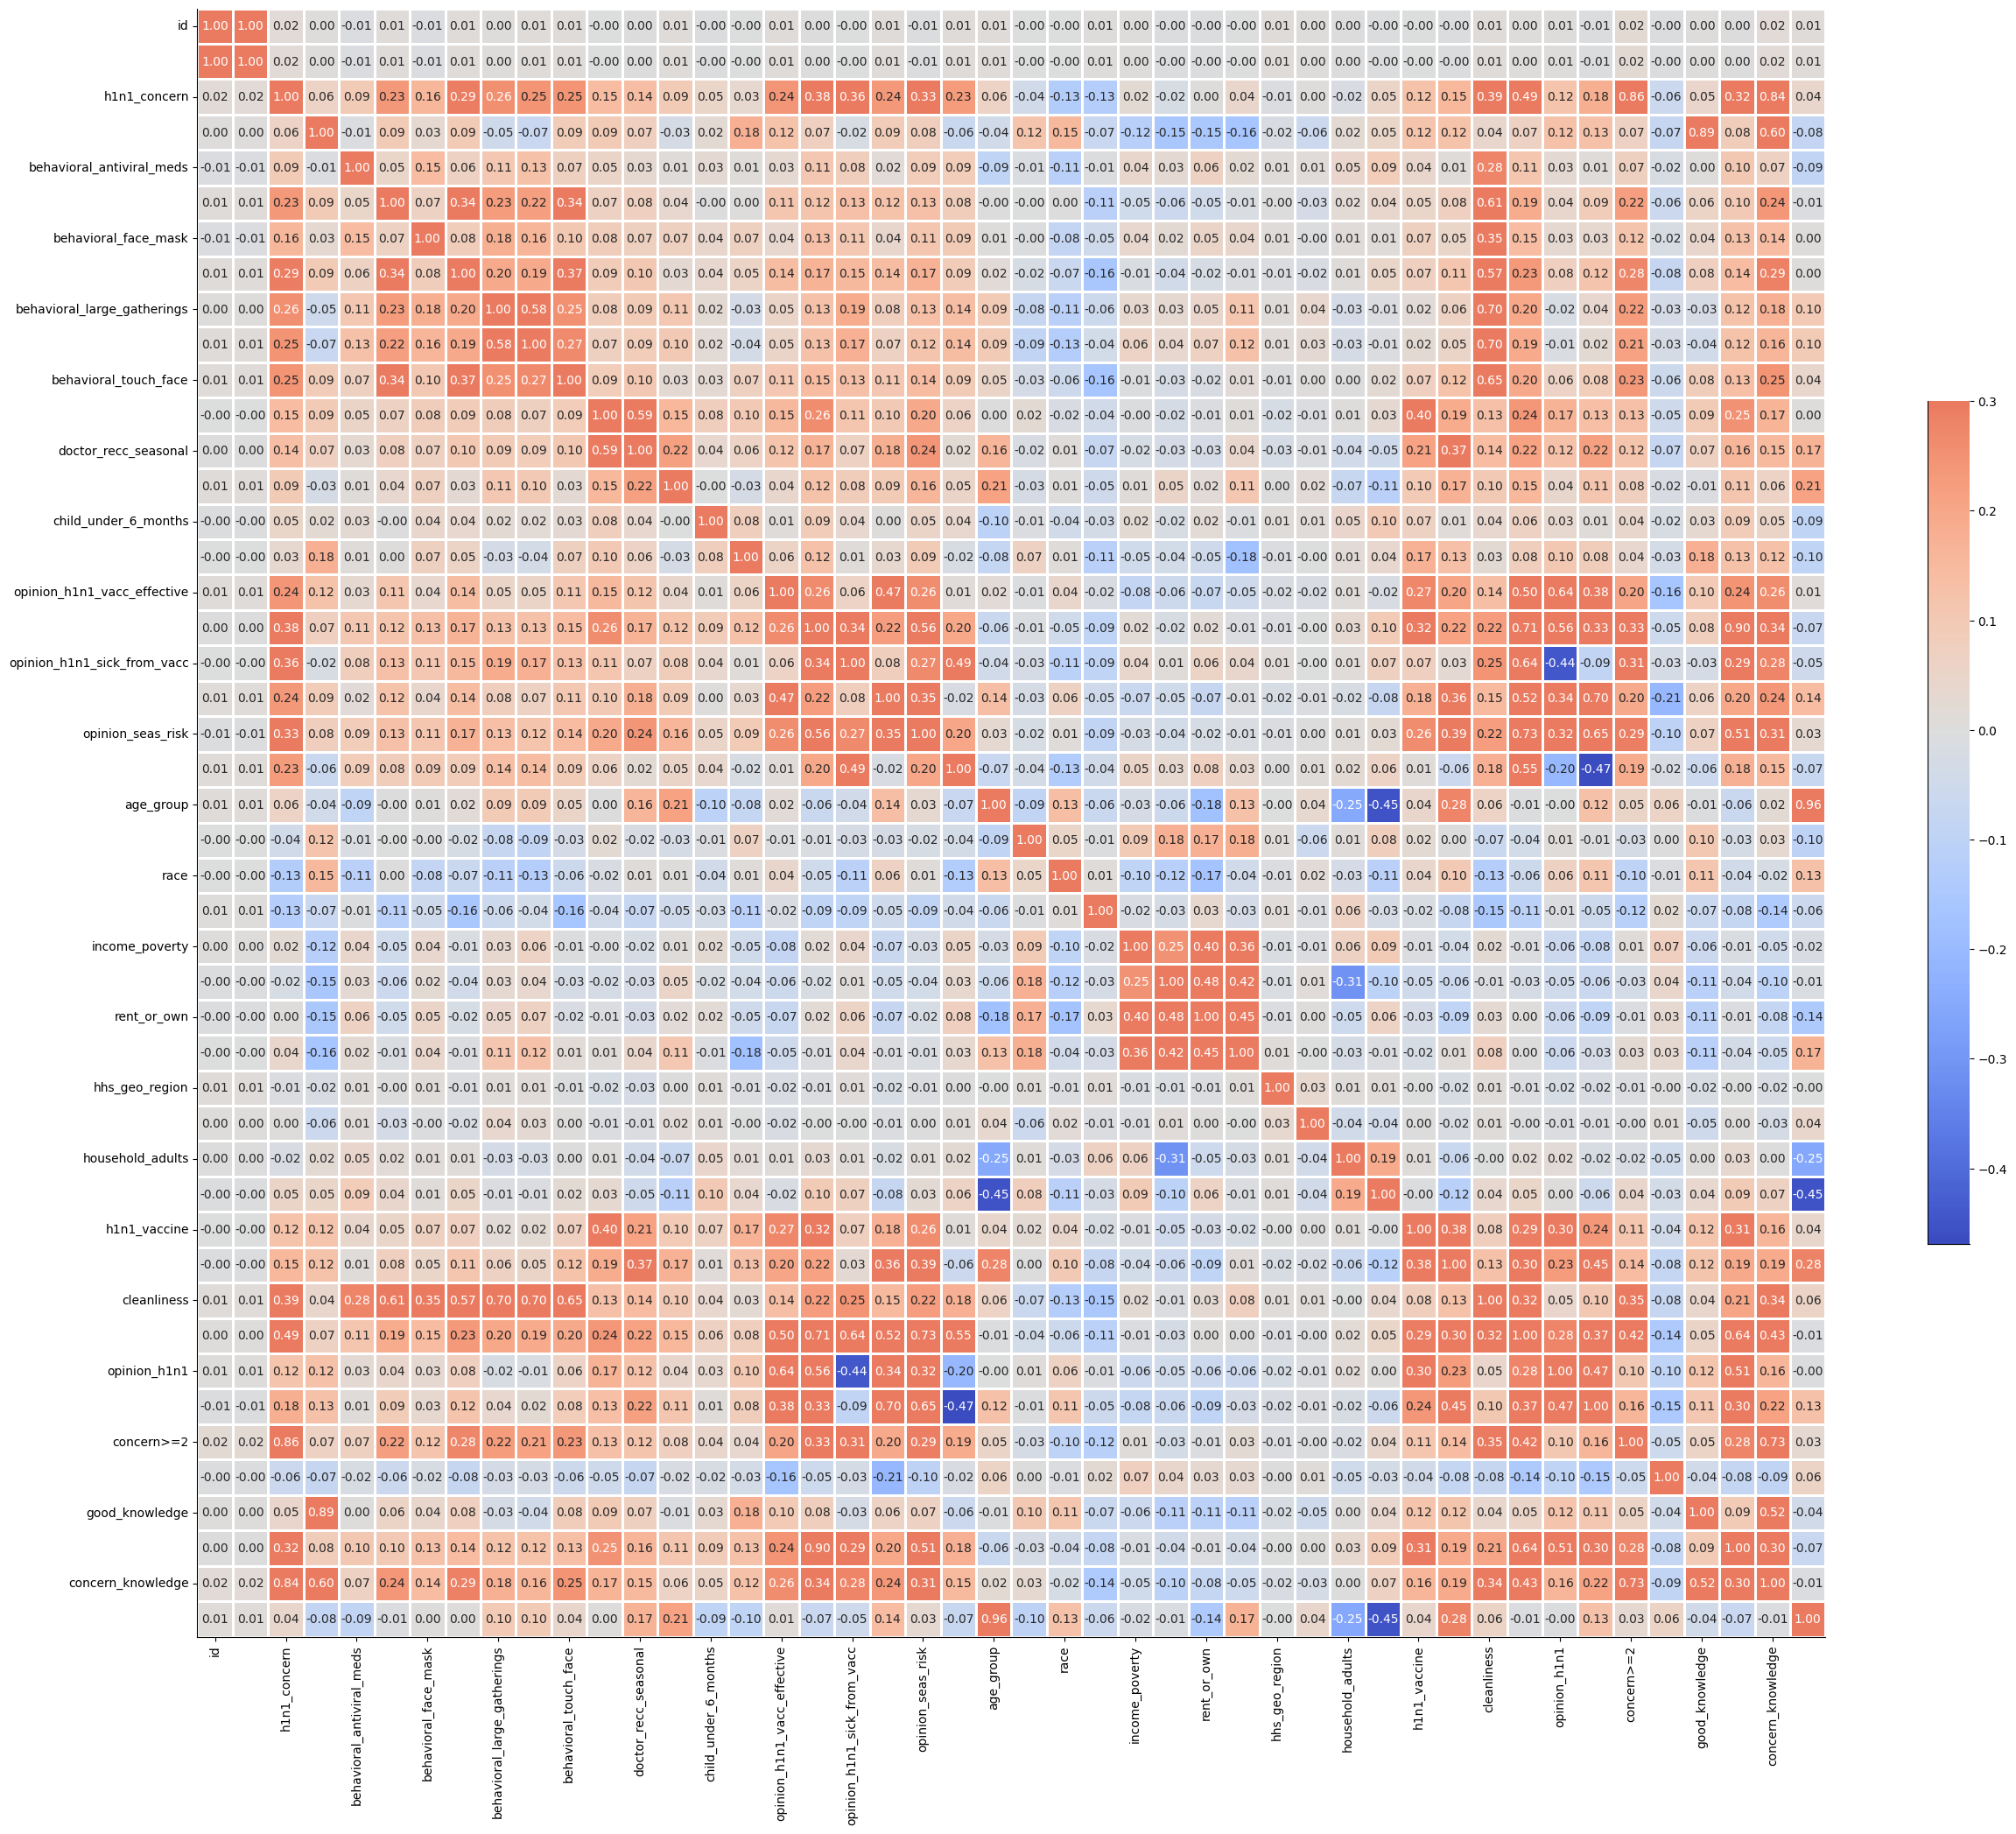

In [31]:
corr = data_m1.corr()
print(corr.columns.tolist())
g = sns.heatmap(corr, vmax=.3, center=0,
                square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(30, 25)
plt.show()

In [32]:
features = data_m1.columns[:-2]
print(features)

Index(['id', 'respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk'],
      dtype='object')


This is excellent. The current set of 26 features shows much better correlation with the ground truth labels compared to the previous set of features. This shows that there is high relevance throughout.

Now, we want to remove features that seem irrelevant to the analysis to simplify the data set that will potentially improve model performance. After dropping these features, we will extract the target labels `h1n1_vaccine` and `seasonal_vaccine` for further analysis:

In [33]:
irrelevant_features = ['race', 'child_under_6_months', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 
                       'household_adults', 'behavioral_antiviral_meds', 'behavioral_large_gatherings', 
                       'behavioral_outside_home', 'behavioral_antiviral_meds', 'marital_status', 
                       'behavioral_avoidance', 'behavioral_face_mask', 'income_poverty', 'hhs_geo_region', 
                       'employment_status', 'education', 'census_msa']

data_m1.drop(irrelevant_features, axis=1, inplace=True)

y_label = data_m1[['h1n1_vaccine', 'seasonal_vaccine']] # getting target labels

We remove `respondent_id` and target labels to avoid interference with feature analysis. `respondent_id` is not predictive and can introduce noise, while the target labels are temporarily removed to focus on feature engineering.

In [34]:
data_m1.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1, inplace=True)

# appending aforementioned y labels to the end of the data_m1
data_m1 = pd.concat([data_m1, y_label], axis=1)

Now we can finally extract feature columns and labels from the data set. This step is necessary for separating the predictors (features) from the target variables (labels) for model training and evaluation:

In [35]:
features = data_m1.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['id', 'h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


##### Method B 

In [36]:
feature_columns_m2 = [
    'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
    'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 
    'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
    'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 
    'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 
    'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 
    'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 
    'household_adults', 'household_children'
]

categorical_columns_m2 = [
    'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 
    'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa'
]

target_columns_m2 = ['h1n1_vaccine', 'seasonal_vaccine']

X_m2 = data_m2[feature_columns_m2]
y_m2 = data_m2[target_columns_m2]

In [37]:
preprocessor_m2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
        ]), [col for col in feature_columns_m2 if col not in categorical_columns_m2]),
        ('cat', OneHotEncoder(drop='first'), categorical_columns_m2)
    ], remainder='passthrough') # defining the column transformer with polynomialfeatures for interaction terms

# define a function to evaluate accuracy for individual classifiers
def find_acc_individual_m2(clf_m2, X_m2, y_m2, target_m2):
    y_pred_m2 = clf_m2.predict(X_m2)
    accuracy_m2 = accuracy_score(y_m2[target_m2], y_pred_m2)
    return accuracy_m2

def ensemble_predict_m2(X_m2, models_m2):
    preds_m2 = np.array([model.predict(X_m2) for model in models_m2])
    return np.mean(preds_m2, axis=0).round().astype(int) # now the final ensemble predictions by averaging the individual model predictions

### Data Splitting

##### Method A: 

To train our model, we split the data set into training (80%) and testing (20%) sets:

In [38]:
train, test = train_test_split(data_m1, test_size=0.2, shuffle=True)

train_x, train_y = train[features], train[labels]
test_x, test_y = test[features], test[labels]

Now this ensures the model is trained on one portion of the data and tested on another, preventing overfitting. We then separate the features (train_x, test_x) from the labels (train_y, test_y) in both the training and testing sets, preparing the data for model training and evaluation.

In [39]:
def transform_test(test_x):
    test_x.drop(['respondent_id', 'health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

    # fill any NULL values
    for col in test_x.columns:
        if test_x[col].isnull().sum():
            if test_x[col].dtypes != 'object':
                test_x[col].fillna(test_x[col].median(), inplace=True)
            else:
                test_x[col].fillna(test_x[col].mode()[0], inplace=True)

    str_cols = test_x.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in str_cols:
        test_x[col] = le.fit_transform(test_x[col])

    test_x['opinion'] = (test_x['opinion_h1n1_vacc_effective'] + test_x['opinion_h1n1_risk'] +
                         test_x['opinion_h1n1_sick_from_vacc'] + test_x['opinion_seas_vacc_effective'] +
                         test_x['opinion_seas_risk'] + test_x['opinion_seas_sick_from_vacc'])

    test_x['cleanliness'] = (test_x['behavioral_antiviral_meds'] + test_x['behavioral_avoidance'] +
                             test_x['behavioral_face_mask'] + test_x['behavioral_wash_hands'] +
                             test_x['behavioral_large_gatherings'] + test_x['behavioral_outside_home'] +
                             test_x['behavioral_touch_face'])

    test_x['opinion_h1n1'] = (test_x['opinion_h1n1_vacc_effective'] + test_x['opinion_h1n1_risk'] -
                              test_x['opinion_h1n1_sick_from_vacc'])

    test_x['opinion_seasonal'] = (test_x['opinion_seas_vacc_effective'] + test_x['opinion_seas_risk'] -
                                  test_x['opinion_seas_sick_from_vacc'])

    test_x['concern>=2'] = (test_x['h1n1_concern'] >= 2).astype(int)
    test_x['good_opinion_vacc'] = (test_x['opinion_seas_vacc_effective'] == 3).astype(int)
    test_x['good_knowledge'] = (test_x['h1n1_knowledge'] == 2).astype(int)
    test_x['risk'] = (test_x['opinion_h1n1_risk'] >= 4).astype(int)
    test_x['concern_knowledge'] = test_x['h1n1_concern'] + test_x['h1n1_knowledge']
    test_x['a^2'] = test_x['age_group'] ** 2

    irrelevant_features = ['race', 'child_under_6_months', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 
                           'household_adults', 'behavioral_antiviral_meds', 'behavioral_large_gatherings', 
                           'behavioral_outside_home', 'behavioral_antiviral_meds', 'marital_status', 
                           'behavioral_avoidance', 'behavioral_face_mask', 'income_poverty', 'hhs_geo_region', 
                           'employment_status', 'education', 'census_msa']
    test_x.drop(irrelevant_features, axis=1, inplace=True)

    return test_x

Let us analyse several models on the data set

In [40]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, model_selection
import xgboost as xgb
import pandas as pd

MLA = [
    # ensemble mthods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # generalised linear models
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # naive bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # knn 
    neighbors.KNeighborsClassifier(),
    
    # svm
    svm.LinearSVC(),
    
    # trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # discriminant analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost
    xgb.XGBClassifier()
]

# defining the cross-validation strategy
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

# initialise dataframe to compare mla metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# initialise dataframe to compare mla predictions
MLA_predict = pd.DataFrame(data_m1['h1n1_vaccine'])

for row_index, alg in enumerate(MLA):
    MLA_name = alg.__class__.__name__
    print('Executing', MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, data_m1[features], data_m1['h1n1_vaccine'], cv=cv_split)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
    
    alg.fit(data_m1[features], data_m1['h1n1_vaccine'])
    MLA_predict

Executing AdaBoostClassifier
Executing BaggingClassifier
Executing ExtraTreesClassifier
Executing GradientBoostingClassifier
Executing RandomForestClassifier
Executing LogisticRegressionCV
Executing PassiveAggressiveClassifier
Executing RidgeClassifierCV
Executing SGDClassifier
Executing Perceptron
Executing BernoulliNB
Executing GaussianNB
Executing KNeighborsClassifier
Executing LinearSVC
Executing DecisionTreeClassifier
Executing ExtraTreeClassifier
Executing LinearDiscriminantAnalysis
Executing QuadraticDiscriminantAnalysis
Executing XGBClassifier


The transform_test function prepares the test set for model evaluation. It drops irrelevant columns, fills missing values, encodes categorical variables, synthesizes new features, and drops other irrelevant features to ensure the test data is in the same format as the training data.

Let's visually compare the various accuracy scores from these models.

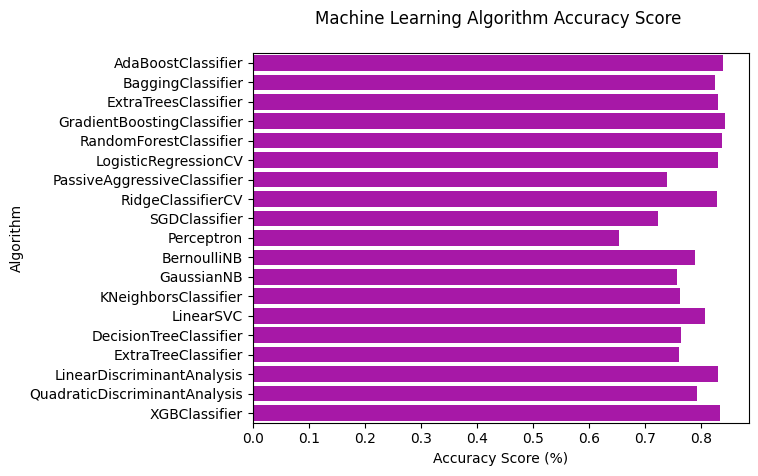

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    accuracy = roc_auc_score(truth, pred)
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

The find_acc function calculates and prints the accuracy of a classifier using the ROC AUC score. This score measures how well the model can distinguish between different classes. The function takes a classifier, the feature data, the true labels, and a label (string) to identify which data set is being evaluatedf.

In [43]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.05)  # use 10% of the data_m1
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

grid_1 = {
    "n_estimators": [100, 200, 500],
    "criterion": ["gini", "entropy"],
    "max_features": ['sqrt', 'log2', 0.2, 0.5, 0.8],
    "max_depth": [3, 4, 6, 10],
    "min_samples_split": [2, 5, 20, 50]
}

rf = RandomForestClassifier()

gs = GridSearchCV(rf, grid_1, n_jobs=-1, cv=2, verbose=True)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray() 
    accuracy = roc_auc_score(truth, pred, average='macro') 
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=gs, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')


Fitting 2 folds for each of 480 candidates, totalling 960 fits
Fitting 2 folds for each of 480 candidates, totalling 960 fits
Training Accuracy is: 94.12%
Cross Validation Accuracy is: 83.48%


There are a few things going on here. Let's break it down:

This block of code performs hyperparameter tuning on a RandomForestClassifier using Grid Search within a BinaryRelevance multi-label classification framework. Refer to the break-down below.

**BREAKDOWN**:

* Subset Selection: Using a small subset (5%) of the training data for faster prototyping.
* Parameter Grid Definition: Defining a grid of hyperparameters for the Grid Search.
* Grid Search Initialization: Setting up Grid Search with cross-validation to find the best hyperparameters.
* Accuracy Evaluation Function: A function to calculate and print the ROC AUC score for model evaluation.
* BinaryRelevance Initialization: Wrapping the Grid Search in a BinaryRelevance classifier to handle multi-label classification.
* Model Training: Training the model on the subset of training data.
* Model Evaluation: Evaluating and printing the accuracy for both the training and cross-validation datasets.

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.1)  # Use 10% of the data_m1
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

n_estimators = [100, 200, 500]
max_features = ['auto', 'sqrt']
max_depth = [15, 20, 25, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=20,
                               cv=3, verbose=2, random_state=42, n_jobs=-1)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray()  # convert sparse matrix to dense array if necessary
    accuracy = roc_auc_score(truth, pred, average='macro')
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=rf_random, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50

/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/base.py", line 666,

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50

/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/sklearn/base.py", line 666,

Training Accuracy is: 99.26%
Cross Validation Accuracy is: 84.24%


We'll now use Randomized Search for hyperparameter tuning on a RandomForestClassifier within a BinaryRelevance multi-label classification framework. We'll follow similar steps as before: using a subset of the data for faster prototyping, defining a parameter grid, setting up Randomized Search, and evaluating accuracy using the ROC AUC score.

The difference is instead of using Grid Search, we are using Randomized Search for hyperparameter tuning. Randomized Search evaluates a random subset of hyperparameter combinations, which can be more efficient when the search space is large.

In [45]:
import tensorflow as tf

def nn_classifier(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


This function defines and compiles a neural network classifier using tensorflows keras API. The neural network consists of an input layer with 25 neurons and ReLU activation, followed by two hidden layers with 128 and 64 neurons respectively, both using ReLU activation. The output layer has a number of neurons equal to output_dim and uses a softmax activation function, making it suitable for multiclass classification. The model is compiled with the binary cross-entropy loss function, the Adam optimiser, and accuracy as a performance metric.

In [46]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.1) 
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

param2 = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3, 4],
    'lambda': [1.0, 1.5],
    'subsample': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.3, 0.5, 0.6],
    'min_split_loss': [0.01, 0.2],
    'min_split_size': [2, 4, 6]
}

# initialise the xgbc
classifier = XGBClassifier(verbosity=0)

xgb = GridSearchCV(estimator=classifier, param_grid=param2, n_jobs=-1, cv=2, verbose=True)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray()  
    accuracy = roc_auc_score(truth, pred, average='macro')
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=xgb, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 2 folds for each of 648 candidates, totalling 1296 fits
Training Accuracy is: 88.91%
Cross Validation Accuracy is: 84.21%


/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


This script follows a similar process to the previous ones, but it uses an XGBClassifier with grid search for hyperparameter tuning. The key differences are:

* Classifier: We are using XGBClassifier instead of RandomForestClassifier.
* Parameter Grid: The parameter grid is tailored for XGBClassifier with specific hyperparameters such as `learning_rate`, `max_depth`, `lambda`, `subsample`, `colsample_bytree`, `min_split_loss`, and `min_split_size`.

In [47]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.05)  
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

n_estimators = [100, 200]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 7, 5, 15, 20, 25, None]
min_samples_split = [0.2, 0.3, 0.6, 1.2, 1.5, 2.0, 3.0, 4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = XGBClassifier(verbosity=0)

etc = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=20,
                         cv=4, verbose=2, random_state=42, n_jobs=-1)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray() 
    accuracy = roc_auc_score(truth, pred, average='macro')
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=etc, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3.0, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3.0, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3.0, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3.0, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=1.2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=1.2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=1.2, n_estimator

This script performs hyperparameter tuning on an XGBClassifier using Randomized Search within a BinaryRelevance multi-label classification framework. The process is similar to previous examples but uses different hyperparameters suitable for XGBClassifier. The key differences include:

* Parameter Grid: A tailored grid for XGBClassifier including parameters like `n_estimators`, `max_features`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `bootstrap`.
* Classifier: Using XGBClassifier with Randomized Search for efficient hyperparameter tuning.

In [48]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.1) 
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

cb_hps = {
    'depth': [2, 3, 4, 5, 7],
    'l2_leaf_reg': [2, 3, 5, 10],
    'random_seed': [5, 8, 10],
    'colsample_bylevel': [0.3, 0.5, 0.6],
    'n_estimators': [100, 200]
}

cb = CatBoostClassifier(verbose=False)

cbt = RandomizedSearchCV(estimator=cb, param_distributions=cb_hps, n_iter=20,
                         cv=4, verbose=2, random_state=42, n_jobs=-1)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray() 
    accuracy = roc_auc_score(truth, pred, average='macro')
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=cbt, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] END colsample_bylevel=0.3, depth=3, l2_leaf_reg=10, n_estimators=100, random_seed=5; total time=   0.3s
[CV] END colsample_bylevel=0.3, depth=3, l2_leaf_reg=10, n_estimators=100, random_seed=5; total time=   0.3s
[CV] END colsample_bylevel=0.3, depth=3, l2_leaf_reg=10, n_estimators=100, random_seed=5; total time=   0.3s
[CV] END colsample_bylevel=0.3, depth=3, l2_leaf_reg=10, n_estimators=100, random_seed=5; total time=   0.3s
[CV] END colsample_bylevel=0.5, depth=7, l2_leaf_reg=3, n_estimators=100, random_seed=10; total time=   0.7s
[CV] END colsample_bylevel=0.5, depth=7, l2_leaf_reg=3, n_estimators=100, random_seed=10; total time=   0.7s
[CV] END colsample_bylevel=0.5, depth=7, l2_leaf_reg=3, n_estimators=100, random_seed=10; total time=   0.7s
[CV] END colsample_bylevel=0.5, depth=7, l2_leaf_reg=3, n_estimators=100, random_seed=10; total time=   0.8s
[CV] END colsample_bylevel=0.6, depth=3, l2_leaf_reg=10, n_estimato

This script performs hyperparameter tuning on a CatBoostClassifier using Randomized Search within a BinaryRelevance multi-label classification framework. The key differences in this script are:

* Classifier: Using CatBoostClassifier.
* Parameter Grid: The parameter grid is tailored for CatBoostClassifier with specific hyperparameters such as `depth`, `l2_leaf_reg`, `random_seed`, `colsample_bylevel`, and `n_estimators`.

In [49]:
import pandas as pd
from catboost import CatBoostClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import roc_auc_score

subset_size = int(len(train_x) * 0.1)  
train_x_subset = train_x.sample(subset_size, random_state=42)
train_y_subset = train_y.loc[train_x_subset.index]

classifier = CatBoostClassifier(
    n_estimators=300,
    depth=5,
    l2_leaf_reg=0.5,
    random_seed=2,
    colsample_bylevel=0.9,
    verbose=False
)

def find_acc(clf, X, truth, s):
    pred = clf.predict_proba(X)
    pred = pred.toarray() 
    accuracy = roc_auc_score(truth, pred, average='macro')
    print(f"{s} Accuracy is: {accuracy * 100:.2f}%")

clf = BinaryRelevance(classifier=classifier, require_dense=[True, True])

clf.fit(train_x_subset, train_y_subset)

find_acc(clf, train_x_subset, train_y_subset, 'Training')
find_acc(clf, test_x, test_y, 'Cross Validation')


Training Accuracy is: 94.61%
Cross Validation Accuracy is: 84.78%


This code block This script performs training and evaluation of a CatBoostClassifier within a BinaryRelevance multi-label classification framework. It uses a subset of the training data for faster prototyping and includes an accuracy evaluation function.

##### Method B:

In [50]:
X_train_df_m2, X_test_df_m2, y_train_m2, y_test_m2 = train_test_split(X_m2, y_m2, test_size=0.2, random_state=42, stratify=y_m2)

X_train_transformed_m2 = preprocessor_m2.fit_transform(X_train_df_m2)
X_test_transformed_m2 = preprocessor_m2.transform(X_test_df_m2)

In [51]:
import warnings
warnings.filterwarnings('ignore')

results_m2 = pd.DataFrame(columns=[
    'Model', 'Best Parameters', 'Training H1N1 Accuracy', 'Test H1N1 Accuracy', 
    'Training Seasonal Accuracy', 'Test Seasonal Accuracy', 
    'Stratified CV H1N1 Accuracy', 'Stratified CV Seasonal Accuracy'
])

additional_models_m2 = [
    (RandomForestClassifier(random_state=42), {
        "classifier__n_estimators": [100, 200],
        "classifier__criterion": ["gini"],
        "classifier__max_features": ['sqrt', 0.5],
        "classifier__max_depth": [4, 6],
        "classifier__min_samples_split": [2, 5]
    }),
    (XGBClassifier(eval_metric='mlogloss', random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.2],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'use_label_encoder': [False]
    }),
    (GradientBoostingClassifier(random_state=42), {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.1, 0.2],
        "classifier__max_depth": [3, 5],
        "classifier__subsample": [0.8, 1.0]
    }),
    (AdaBoostClassifier(random_state=42, algorithm='SAMME'), {
        "classifier__n_estimators": [50, 100],
        "classifier__learning_rate": [0.1, 1.0]
    }),
    (LogisticRegression(max_iter=1000, random_state=42), {
        "classifier__C": [0.01, 0.1, 1, 10],
        "classifier__penalty": ['l2']
    }),
    (RidgeClassifierCV(), {}),
    (GaussianNB(), {}),
    (KNeighborsClassifier(), {
        "classifier__n_neighbors": [5, 10],
        "classifier__weights": ['uniform', 'distance']
    }),
    (SVC(probability=True, random_state=42), {
        "classifier__C": [0.1, 1, 10],
        "classifier__gamma": [0.01, 0.1, 1]
    }),
    (DecisionTreeClassifier(random_state=42), {
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [4, 6, None]
    }),
    (LinearDiscriminantAnalysis(), {})
]

In [52]:
import warnings
warnings.filterwarnings('ignore')

for clf_m2, param_grid_m2 in additional_models_m2:
    model_name_m2 = clf_m2.__class__.__name__
    print(f"\nEvaluating {model_name_m2}")

    pipeline_h1n1_m2 = Pipeline([
        ('selector', SelectKBest(f_classif, k=10)),
        ('classifier', clf_m2)
    ])

    pipeline_seasonal_m2 = Pipeline([
        ('selector', SelectKBest(f_classif, k=10)),
        ('classifier', clf_m2)
    ])

    if isinstance(clf_m2, XGBClassifier):
        halving_search_h1n1_m2 = HalvingGridSearchCV(clf_m2, param_grid_m2, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
        halving_search_seasonal_m2 = HalvingGridSearchCV(clf_m2, param_grid_m2, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    else:
        halving_search_h1n1_m2 = HalvingGridSearchCV(pipeline_h1n1_m2, param_grid_m2, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
        halving_search_seasonal_m2 = HalvingGridSearchCV(pipeline_seasonal_m2, param_grid_m2, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

    halving_search_h1n1_m2.fit(X_train_transformed_m2, y_train_m2['h1n1_vaccine'])
    best_h1n1_m2 = halving_search_h1n1_m2.best_estimator_
    best_params_h1n1_m2 = halving_search_h1n1_m2.best_params_

    halving_search_seasonal_m2.fit(X_train_transformed_m2, y_train_m2['seasonal_vaccine'])
    best_seasonal_m2 = halving_search_seasonal_m2.best_estimator_
    best_params_seasonal_m2 = halving_search_seasonal_m2.best_params_

    train_h1n1_acc_m2 = find_acc_individual_m2(best_h1n1_m2, X_train_transformed_m2, y_train_m2, 'h1n1_vaccine')
    test_h1n1_acc_m2 = find_acc_individual_m2(best_h1n1_m2, X_test_transformed_m2, y_test_m2, 'h1n1_vaccine')
    train_seasonal_acc_m2 = find_acc_individual_m2(best_seasonal_m2, X_train_transformed_m2, y_train_m2, 'seasonal_vaccine')
    test_seasonal_acc_m2 = find_acc_individual_m2(best_seasonal_m2, X_test_transformed_m2, y_test_m2, 'seasonal_vaccine')

    skf_m2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    h1n1_cv_scores_m2 = []
    seasonal_cv_scores_m2 = []

    for train_index_m2, val_index_m2 in skf_m2.split(X_train_df_m2, y_train_m2['h1n1_vaccine']):
        X_train_fold_m2, X_val_fold_m2 = X_train_df_m2.iloc[train_index_m2], X_train_df_m2.iloc[val_index_m2]
        y_train_fold_m2, y_val_fold_m2 = y_train_m2.iloc[train_index_m2], y_train_m2.iloc[val_index_m2]
        
        X_train_fold_transformed_m2 = preprocessor_m2.fit_transform(X_train_fold_m2)
        X_val_fold_transformed_m2 = preprocessor_m2.transform(X_val_fold_m2)

        best_h1n1_m2.fit(X_train_fold_transformed_m2, y_train_fold_m2['h1n1_vaccine'])
        best_seasonal_m2.fit(X_train_fold_transformed_m2, y_train_fold_m2['seasonal_vaccine'])
        
        h1n1_preds_val_m2 = ensemble_predict_m2(X_val_fold_transformed_m2, [best_h1n1_m2])
        seasonal_preds_val_m2 = ensemble_predict_m2(X_val_fold_transformed_m2, [best_seasonal_m2])
        
        h1n1_cv_scores_m2.append(accuracy_score(y_val_fold_m2['h1n1_vaccine'], h1n1_preds_val_m2))
        seasonal_cv_scores_m2.append(accuracy_score(y_val_fold_m2['seasonal_vaccine'], seasonal_preds_val_m2))

    stratified_cv_h1n1_acc_m2 = np.mean(h1n1_cv_scores_m2)
    stratified_cv_seasonal_acc_m2 = np.mean(seasonal_cv_scores_m2)

    results_m2 = pd.concat([results_m2, pd.DataFrame([{
        'Model': model_name_m2,
        'Best Parameters': best_params_h1n1_m2,
        'Training H1N1 Accuracy': train_h1n1_acc_m2,
        'Test H1N1 Accuracy': test_h1n1_acc_m2,
        'Training Seasonal Accuracy': train_seasonal_acc_m2,
        'Test Seasonal Accuracy': test_seasonal_acc_m2,
        'Stratified CV H1N1 Accuracy': stratified_cv_h1n1_acc_m2,
        'Stratified CV Seasonal Accuracy': stratified_cv_seasonal_acc_m2
    }])], ignore_index=True)


Evaluating RandomForestClassifier

Evaluating XGBClassifier


/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ab/opt/anaconda3/envs/lightgbm_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:42:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab


Evaluating GradientBoostingClassifier

Evaluating AdaBoostClassifier

Evaluating LogisticRegression

Evaluating RidgeClassifierCV

Evaluating GaussianNB

Evaluating KNeighborsClassifier

Evaluating SVC

Evaluating DecisionTreeClassifier

Evaluating LinearDiscriminantAnalysis


In [53]:
results_m2 = results_m2.sort_values(by='Stratified CV H1N1 Accuracy', ascending=False)

from IPython.display import display #  display results as a formatted table
display(results_m2)

,Model,Best Parameters,Training H1N1 Accuracy,Test H1N1 Accuracy,Training Seasonal Accuracy,Test Seasonal Accuracy,Stratified CV H1N1 Accuracy,Stratified CV Seasonal Accuracy
4,LogisticRegression,"{'classifier__C': 10, 'classifier__penalty': '...",0.832397,0.848598,0.775281,0.742056,0.829584,0.775272
5,RidgeClassifierCV,{},0.833333,0.842991,0.771067,0.740187,0.829583,0.767314
10,LinearDiscriminantAnalysis,{},0.830993,0.842991,0.772940,0.738318,0.829119,0.767782
1,XGBClassifier,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.900281,0.842991,0.866573,0.751402,0.826313,0.779954
9,DecisionTreeClassifier,"{'classifier__criterion': 'entropy', 'classifi...",0.836610,0.835514,0.780899,0.734579,0.826310,0.776212
8,SVC,"{'classifier__C': 1, 'classifier__gamma': 0.01}",0.835674,0.844860,0.801498,0.753271,0.826307,0.774800
0,RandomForestClassifier,"{'classifier__criterion': 'gini', 'classifier_...",0.838015,0.839252,0.781367,0.736449,0.824434,0.771992
3,AdaBoostClassifier,"{'classifier__learning_rate': 1.0, 'classifier...",0.831929,0.846729,0.770599,0.740187,0.823967,0.775266
2,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.847378,0.842991,0.809925,0.745794,0.818815,0.779012
7,KNeighborsClassifier,"{'classifier__n_neighbors': 10, 'classifier__w...",0.839888,0.831776,0.823034,0.742056,0.816010,0.767316
